In [1]:
!pip install -q statsforecast

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [138]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.utils import AirPassengersDF

df = AirPassengersDF
sf = StatsForecast(
    models = [AutoARIMA(season_length = 12)],
    freq = 'M'
)

sf.fit(df)
result = sf.predict(h=12, level=[95])

In [143]:
df

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0
...,...,...,...
139,1.0,1960-08-31,606.0
140,1.0,1960-09-30,508.0
141,1.0,1960-10-31,461.0
142,1.0,1960-11-30,390.0


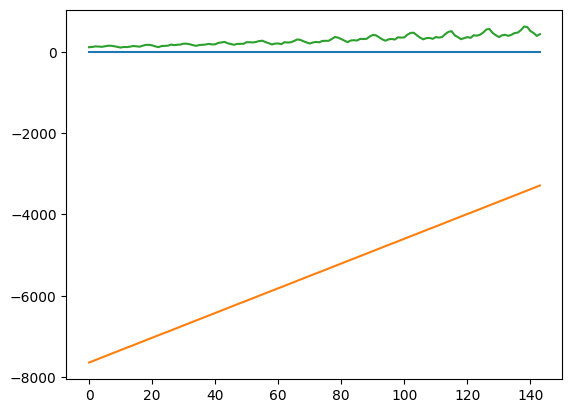

In [142]:
# Visualize the results using Seaborn
plt.plot(df, label='Actual Data')
plt.show()

In [139]:
result

,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95
unique_id,,,,
1.0,1961-01-31,447.970184,425.082367,470.858002
1.0,1961-02-28,423.797028,397.261871,450.332214
1.0,1961-03-31,453.488770,423.935089,483.042450
1.0,1961-04-30,496.700043,465.171478,528.228577
1.0,1961-05-31,508.640991,475.603027,541.678955
1.0,1961-06-30,572.352173,538.131958,606.572449
1.0,1961-07-31,659.894653,624.701416,695.087830
1.0,1961-08-31,644.307129,608.285767,680.328430
1.0,1961-09-30,546.621094,509.873230,583.368896


In [3]:
activities = pd.read_parquet('../data-raw/activities.parquet')

In [9]:
activities_by_day = (
    activities
    .assign(date=pd.to_datetime(activities['date']).dt.date)
    # Grouping data by contributor and date, and counting up the activities by day
    .groupby(['contributor', 'category', 'date'])
    .activity
    .count()
    .reset_index(name='n_activities')
)
activities_by_day.sample(15)

,contributor,category,date,n_activities
943,353444,human,2023-01-17,10
41135,meeseeksdev[bot],bot,2022-11-29,5
15914,746683,human,2023-02-10,5
19446,833435,human,2022-12-14,4
39340,istio-policy-bot,bot,2023-04-14,7
15442,739663,human,2023-03-02,1
29648,aviary2-wf,bot,2023-01-14,1
36605,garybot2,bot,2022-12-14,39
32890,confs-tech-bot,bot,2023-02-21,12
10823,587344,human,2023-03-08,9


In [20]:
activities_by_time = (
    activities
    .assign(datetime=activities['date'].dt.strftime('%Y-%m-%d %H:00:00'))
    .groupby(['contributor', 'category', 'datetime'])
    .activity
    .count()
    .unstack(fill_value=0).stack()
    .reset_index(name='n_activities')
    .fillna(0)
)
activities_by_time.head(24)

,contributor,category,datetime,n_activities
0,0crat,bot,2022-11-25 09:00:00,0
1,0crat,bot,2022-11-25 10:00:00,0
2,0crat,bot,2022-11-25 11:00:00,1
3,0crat,bot,2022-11-25 12:00:00,1
4,0crat,bot,2022-11-25 13:00:00,6
5,0crat,bot,2022-11-25 14:00:00,12
6,0crat,bot,2022-11-25 15:00:00,10
7,0crat,bot,2022-11-25 16:00:00,8
8,0crat,bot,2022-11-25 17:00:00,2
9,0crat,bot,2022-11-25 18:00:00,0


In [132]:
# Get the data of the top contributor 'sourcegraph-bot, codeclimate[bot]' to test time series decomposition method
temp = (
    activities_by_day[activities_by_day['contributor'] == 'sourcegraph-bot']
    .drop(['contributor', 'category'], axis=1)
    .reset_index(drop=True)
    .fillna(0)
)
temp["date"] = pd.to_datetime(temp["date"])

# Statsforecast specifications
temp["unique_id"]="1"
temp.columns=["ds", "y", "unique_id"]
temp.tail(10)

,ds,y,unique_id
132,2023-04-06,251,1
133,2023-04-07,237,1
134,2023-04-08,65,1
135,2023-04-09,51,1
136,2023-04-10,200,1
137,2023-04-11,262,1
138,2023-04-12,290,1
139,2023-04-13,286,1
140,2023-04-14,221,1
141,2023-04-15,43,1


In [93]:
temp.dtypes

ds           datetime64[ns]
y                     int64
unique_id            object
dtype: object

In [133]:
Y_train_df = temp[(temp.ds>'2023-02-05') & (temp.ds<='2023-04-05')] 
Y_test_df = temp[temp.ds>'2023-04-05']

In [134]:
Y_train_df.shape, Y_test_df.shape

((59, 3), (10, 3))

In [124]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

In [101]:
# Assuming that the data is stored in a pandas dataframe named 'df'
sf = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D')
sf.fit(Y_train_df)
forecast = sf.predict(h=24, level=[95])

In [135]:
# Assuming that the data is stored in a pandas dataframe named 'df'
sf = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D')
sf.fit(Y_train_df)
forecast = sf.predict(h=10, level=[95])

In [136]:
forecast

,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95
unique_id,,,,
1,2023-04-06,314.705688,246.655609,382.755737
1,2023-04-07,272.122101,198.684418,345.559784
1,2023-04-08,65.375732,-8.911080,139.662552
1,2023-04-09,36.108944,-38.315010,110.532898
1,2023-04-10,270.291199,195.855072,344.727325
1,2023-04-11,296.125732,221.685867,370.565613
1,2023-04-12,322.602234,248.161728,397.042725
1,2023-04-13,312.921387,234.728302,391.114471
1,2023-04-14,271.398163,192.604523,350.191803


In [137]:
Y_test_df

,ds,y,unique_id
132,2023-04-06,251,1
133,2023-04-07,237,1
134,2023-04-08,65,1
135,2023-04-09,51,1
136,2023-04-10,200,1
137,2023-04-11,262,1
138,2023-04-12,290,1
139,2023-04-13,286,1
140,2023-04-14,221,1
141,2023-04-15,43,1


In [60]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string

In [76]:
season_length = 24 # Daily data 
horizon = len(Y_test_df) # number of predictions

models = [AutoARIMA(season_length=season_length)]

In [77]:
sf = StatsForecast(df=Y_train_df,
                   models=models,
                   freq='D', 
                   n_jobs=-1)

In [78]:
sf.fit()

StatsForecast(models=[AutoARIMA])

In [79]:
StatsForecast(models=[AutoARIMA], freq='D')

StatsForecast(models=[<class 'statsforecast.models.AutoARIMA'>])

In [111]:
arima_string(sf.fitted_[0,0].model_)

'ARIMA(1,0,0)(0,1,1)[7]                   '

In [112]:
result=sf.fitted_[0,0].model_
print(result.keys())
print(result['arma'])

dict_keys(['coef', 'sigma2', 'var_coef', 'mask', 'loglik', 'aic', 'arma', 'residuals', 'code', 'n_cond', 'nobs', 'model', 'bic', 'aicc', 'ic', 'xreg', 'x', 'lambda'])
(1, 0, 0, 1, 7, 0, 1)


In [113]:
residual=pd.DataFrame(result.get("residuals"), columns=["residual Model"])
residual


,residual Model
0,0.142000
1,0.191000
2,0.111000
3,0.313000
4,0.449999
...,...
127,-71.051693
128,101.700769
129,-40.730105
130,55.273799


In [114]:
Y_hat_df = sf.forecast(horizon, fitted=True)

Y_hat_df.head()


,ds,AutoARIMA
unique_id,,
1,2023-04-06,449.585754
1,2023-04-07,444.800201
1,2023-04-08,235.787491
1,2023-04-09,178.226242
1,2023-04-10,607.578979


In [84]:
values=sf.forecast_fitted_values()
values

,ds,y,AutoARIMA
unique_id,,,
1,2022-11-25,2.0,0.585786
1,2022-11-26,2.0,2.239775
1,2022-11-27,2.0,2.165080
1,2022-11-28,2.0,1.717153
1,2022-11-29,2.0,1.477810
...,...,...,...
1,2023-04-01,2.0,1.744154
1,2023-04-02,2.0,1.746721
1,2023-04-03,2.0,1.742338


In [88]:
sf.predict(h=12, level=[99])

,ds,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-hi-99
unique_id,,,,
1,2023-04-06,1.709656,0.576703,2.842609
1,2023-04-07,1.462385,-0.238610,3.163380
1,2023-04-08,1.151206,-1.038282,3.340694
1,2023-04-09,0.869564,-1.648019,3.387147
1,2023-04-10,0.661502,-2.019079,3.342083
1,2023-04-11,0.548650,-2.178777,3.276078
1,2023-04-12,0.548650,-2.178777,3.276078
1,2023-04-13,0.548650,-2.178777,3.276078
1,2023-04-14,0.548650,-2.178777,3.276078


In [86]:
Y_hat_df=Y_hat_df.reset_index()
Y_hat_df


,unique_id,ds,AutoARIMA
0,1,2023-04-06,1.709656
1,1,2023-04-07,1.462385
2,1,2023-04-08,1.151206
3,1,2023-04-09,0.869564
4,1,2023-04-10,0.661502
5,1,2023-04-11,0.548650
6,1,2023-04-12,0.548650
7,1,2023-04-13,0.548650
8,1,2023-04-14,0.548650
9,1,2023-04-15,0.548650


/var/folders/x_/_4_hxhrn64sgbhxvknd014l80000gn/T/ipykernel_5150/1626305839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_test_df['unique_id'] = Y_test_df['unique_id'].astype(int)


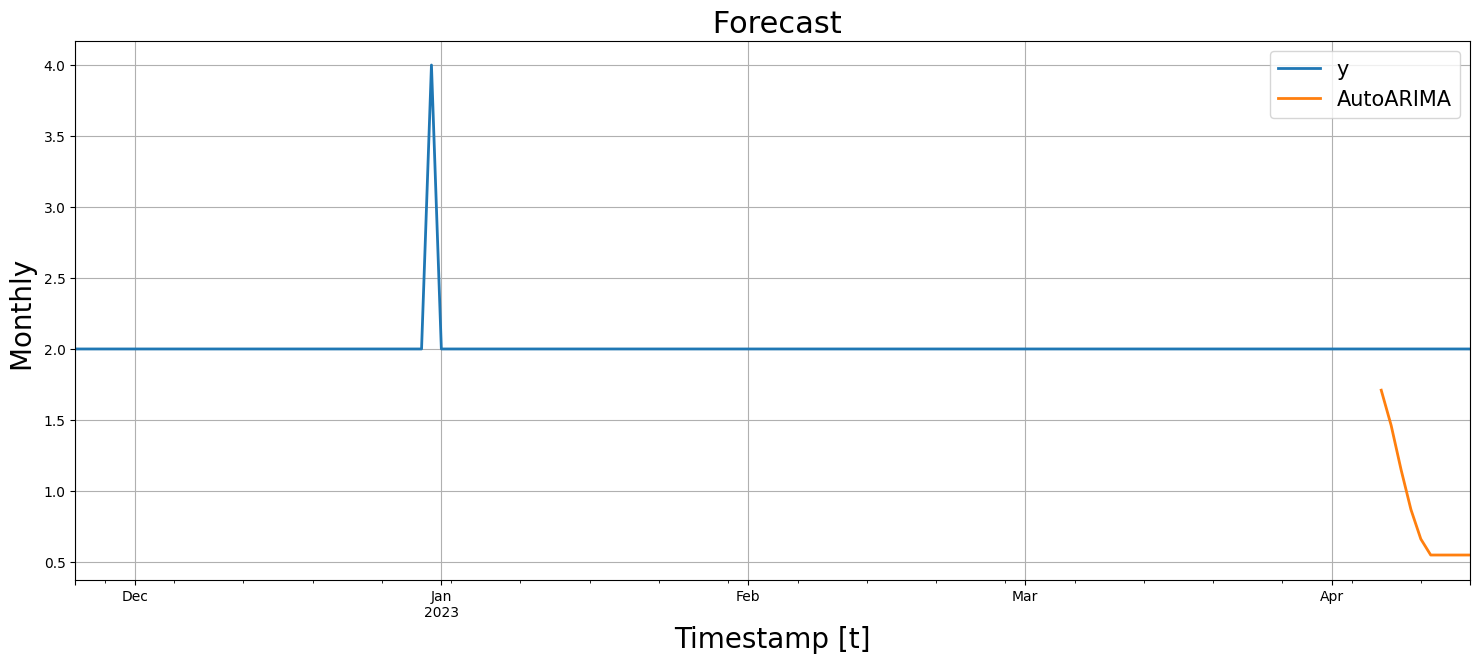

In [87]:
Y_test_df['unique_id'] = Y_test_df['unique_id'].astype(int)
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])

fig, ax = plt.subplots(1, 1, figsize = (18, 7))
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')
plot_df[['y', 'AutoARIMA']].plot(ax=ax, linewidth=2)
ax.set_title(' Forecast', fontsize=22)
ax.set_ylabel('Monthly ', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [ ]:
from statsforecast.models import auto_arima
from statsforecast.core import StatsForecast

# Load your data into a pandas dataframe
df = pd.read_csv('your_data.csv')

# Create a StatsForecast object and fit the model
fcst = StatsForecast(df, models=[auto_arima], freq='D')
fcst.fit()

# Generate forecasts
forecasts = fcst.forecast(7)

# Print the forecasts
print(forecasts)


In [ ]:
import numpy as np
import pandas as pd

import scipy.stats as stats


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (18,7)


In [ ]:
df = pd.read_csv("../data-raw/candy_production.csv")
df.head()


In [ ]:
df["unique_id"]="1"
df.columns=["ds", "y", "unique_id"]
df.head()


In [ ]:
print(df.dtypes)

In [ ]:
df["ds"] = pd.to_datetime(df["ds"])

In [ ]:
from statsforecast import StatsForecast

StatsForecast.plot(df, engine="matplotlib")


In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(df["y"],  lags=60, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

plot_pacf(df["y"],  lags=60, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose 
a = seasonal_decompose(df["y"], model = "add", period=12)
a.plot();


In [ ]:
Y_train_df = df[df.ds<='2016-08-01'] 
Y_test_df = df[df.ds>'2016-08-01']

In [ ]:
Y_train_df.shape, Y_test_df.shape


In [ ]:
sns.lineplot(Y_train_df,x="ds", y="y", label="Train")
sns.lineplot(Y_test_df, x="ds", y="y", label="Test")
plt.show()


In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string


In [ ]:
season_length = 12 # Monthly data 
horizon = len(Y_test_df) # number of predictions

models = [AutoARIMA(season_length=season_length)]


In [ ]:
sf = StatsForecast(df=Y_train_df,
                   models=models,
                   freq='MS', 
                   n_jobs=-1)

In [ ]:
sf.fit()


In [ ]:
StatsForecast(models=[AutoARIMA], freq='MS')

In [ ]:
arima_string(sf.fitted_[0,0].model_)


In [ ]:
result=sf.fitted_[0,0].model_
print(result.keys())
print(result['arma'])

In [ ]:
residual=pd.DataFrame(result.get("residuals"), columns=["residual Model"])
residual


In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2)

# plot[1,1]
residual.plot(ax=axs[0,0])
axs[0,0].set_title("Residuals");

# plot
sns.distplot(residual, ax=axs[0,1]);
axs[0,1].set_title("Density plot - Residual");

# plot
stats.probplot(residual["residual Model"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')

# plot
plot_acf(residual,  lags=35, ax=axs[1,1],color="fuchsia")
axs[1,1].set_title("Autocorrelation");

plt.show();


In [ ]:
Y_hat_df = sf.forecast(horizon, fitted=True)

Y_hat_df.head()


In [ ]:
Y_hat_df.tail()


In [ ]:
values=sf.forecast_fitted_values()
values

In [ ]:
sf.forecast(h=12, level=[95])


In [ ]:
Y_hat_df=Y_hat_df.reset_index()
Y_hat_df

In [ ]:
Y_test_df['unique_id'] = Y_test_df['unique_id'].astype(int)
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])

fig, ax = plt.subplots(1, 1, figsize = (18, 7))
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')
plot_df[['y', 'AutoARIMA']].plot(ax=ax, linewidth=2)
ax.set_title(' Forecast', fontsize=22)
ax.set_ylabel('Monthly ', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()
